In [1]:
import openrtdynamics2.lang as dy
import openrtdynamics2.lang.circular_buffer as rb
import openrtdynamics2.py_execute as dyexe
from openrtdynamics2.ORTDtoNumpy import ORTDtoNumpy

import numpy as np
import matplotlib.pyplot as plt
import math

# Purpose

The aim of this example is to illustrate how to
   * use subsystems and control structures to build a module to interpolate asynchronous input data,
   * generate c++ code, and
   * how to use the generated code in custom c++/Python code.

# Interpolation of asynchronous input data

This example considers an interpolation strategy for asynchronous sampled intput data. A typical example would be a control system that is given set points (in an potentially asynchronous way) that describe which reference value to apply at a given time.

Herein, a trajectory $r$ is given by discrete samples (enumerated by the index $j$) that describe the value $v_j$ of an input signal at a given time $t_j$:

$v_j = r( t_j )$.

Herein, the time instances $t_j$ are not necessarily regular, and, hence interpolation can be applied to obtain samples for time instances in-between the instances $t_j$ given by the trajectory.  

Further, when processing such data in real-time in a system using different time instances for sampling, e.g., traditional reglar sampling given a fixed sampling rate, data must be synchronized.

In this example, it is assumed that the data processing system (e.g., a controller) expects the samples ($t_j, v_j$) of the input trajectory to be transmitted via its sampled input data. As, the time instances $t_j$ can be asynchronous to the update rate of the data processing system, for each input sample, a validation flag is added that indicates if the given input sample contains a valid trajectory sample ($t_j, v_j$). In case the flag is set to invalid, the corresponding data shall be ignored.

Please note that the current time-horizon of the input trajectory ($t_j$ for the most recent sample available to the current time $t$) might be far ahead, i.e., the samples of the trajectory can be generated ahead. This yields samples ($t_j, v_j$) with $ t_j > t $ that have to be accumulated before they can be processed. Therefore, a circular buffer is used in the implementation to store the input samples that cannot be processed immediately.

An example set of input trajectory data is given by:

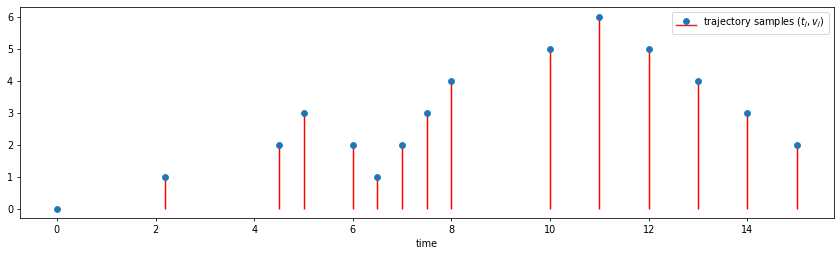

In [2]:
nan = math.nan

async_input_data_valid     = np.array([ 1,   0,   1,   0,   0,   1,   0,   0,   0,   1,   0,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1 ])
reference_trajectory_time  = np.array([ 0, nan, 2.2, nan, nan, 4.5, nan, nan, nan, 5.0, nan, 6.0, 6.5,  7 , 7.5,   8, nan, nan, nan, nan, nan, 10 ,  11,  12,  13,  14,  15 ])
reference_trajectory_value = np.array([ 0, nan, 1.0, nan, nan, 2.0, nan, nan, nan, 3.0, nan, 2.0, 1.0, 2.0, 3.0, 4.0, nan, nan, nan, nan, nan, 5.0, 6.0, 5.0, 4.0, 3.0, 2.0 ])

plt.figure(figsize=(15,4), dpi=70)
plt.stem( reference_trajectory_time, reference_trajectory_value, 'r' )
plt.xlabel('time')
plt.legend(['trajectory samples ($t_j, v_j$)'])
plt.show()

# extend the end of the input data with invalid samples to prolong the simulation
async_input_data_valid     = np.concatenate(( async_input_data_valid,         np.zeros(10) ))
reference_trajectory_time  = np.concatenate(( reference_trajectory_time,  nan*np.zeros(10) ))
reference_trajectory_value = np.concatenate(( reference_trajectory_value, nan*np.zeros(10) ))

The implamentation is given as follows:

In [3]:
def interpolate(sampling_time, reference):

    # feedback signals
    last_read_position = dy.signal()

    # real wourld time
    current_time = dy.sum( sampling_time )

    #
    # find the next sample of the input trajectory ahead of the current time
    #
    
    with dy.sub_loop( max_iterations=1000 ) as loop:

        read_position = dy.sum(1, initial_state=last_read_position)         
        reference_time            = rb.read_from_absolute_index(reference['time'], read_position)
        
        #
        step_to_next_input_sample = current_time > reference_time
        loop.loop_until( dy.logic_not(step_to_next_input_sample) )
        
        # outputs
        loop.set_outputs([ read_position, reference_time ])


    read_position       = loop.outputs[0]
    last_read_position << dy.delay( read_position )

    #
    # read the values of the trajectory and perform interpolation
    #
    
    # NOTE: if read_position-1 < 0 then the data for the linear interpolation is invalid
    
    time_of_sample_ahead   = rb.read_from_absolute_index(reference['time'], read_position)
    time_of_sample_behind  = rb.read_from_absolute_index(reference['time'], read_position-1)

    value_of_sample_ahead  = rb.read_from_absolute_index(reference['values'], read_position)
    value_of_sample_behind = rb.read_from_absolute_index(reference['values'], read_position-1)
    
    #
    # sliding window with read operations are performed:
    #
    # [ minimal_read_position : read_position ]
    #
    
    # communicate that one sample before read_position is still needed and shall not
    # get overwritten by new data in the circular buffer
    minimal_read_position = read_position - 1

    # zero-order hold forward interpolation (targetring the upcoming support point of the input reference trajectory)
    y_zero_order = value_of_sample_ahead
    
    # linear interpolation
    dt = time_of_sample_ahead  - time_of_sample_behind
    dv = value_of_sample_ahead - value_of_sample_behind
    
    y_linear = value_of_sample_behind  +  dv / dt * (current_time - time_of_sample_behind)
    

    return current_time, read_position, minimal_read_position, y_zero_order, y_linear



@ORTDtoNumpy()
def async_interpolation(sampling_time, async_input_data_valid, reference_trajectory_time, reference_trajectory_value):
    
    samples_in_buffer = 50
        
    # allocate the buffers to collect the input data
    reference = {}
    reference['time']   = rb.new_circular_buffer_float64(samples_in_buffer)
    reference['values'] = rb.new_circular_buffer_float64(samples_in_buffer)

    # feedback variables
    current_read_position  = dy.signal()
    current_time           = dy.signal()
    elements_free_to_write = dy.signal()
    
    
    # write new data into the buffer as valid samples arrive 
    with dy.sub_if(async_input_data_valid) as system:

        rb.append_to_buffer(reference['time'],   reference_trajectory_time)
        rb.append_to_buffer(reference['values'], reference_trajectory_value)

        
    #
    # compute the amount of data available ahead
    #
    
    # the duration of the horizonat must be at least the sampling time (and a bit more, 20%) 
    required_time_ahead = sampling_time * 1.2

    head_index = rb.get_current_absolute_write_index(reference['time']) - 1
        
    #
    time_at_the_end_of_horizon = rb.read_from_absolute_index(reference['time'], head_index)
    time_ahead = time_at_the_end_of_horizon - current_time
    
    
    #
    # state machine to determine if more data is required
    #
    with dy.sub_statemachine( "sync_control", immediate_state_switch=True ) as switch:

        with switch.new_subsystem('wait_for_more_data') as system:
            
            # the confition for a sufficient amount of data
            sufficient_amount_of_data = time_ahead >= required_time_ahead
            
            sync_control = dy.int32(-2) # ask for more data

            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=sufficient_amount_of_data, new_value=1 )
            system.set_switched_outputs([ sync_control ], next_state)
            
    
        with switch.new_subsystem('process_data') as system:
            
            # the condition for low amount of data
            low_amount_of_data = time_ahead < required_time_ahead
            buffer_overflow    = elements_free_to_write <= 0
            
            sync_control = dy.int32(-1) # run control and yield valid control commands
                    
            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=low_amount_of_data, new_value=0 )
            next_state = dy.conditional_overwrite(signal=next_state,   condition=buffer_overflow,    new_value=2 ) # error
            system.set_switched_outputs([ sync_control ], next_state)


        with switch.new_subsystem('error') as system:
            # This is an error state that is entered when a buffer overflow happens,
            # i.e., when input data is passed though no more free space is available
            # in the circular buffer.
            
            sync_control = dy.int32(-3) # error code
            system.set_switched_outputs([ sync_control ], dy.int32(-1) )

    
    sync_control = switch.outputs[0]

    
    #
    # Execute the data processing system in case vaild reference data is 
    # available. Otherwise the output variables are undefined and shall be 
    # discarded by the system in which this schematic is embedded into.
    #
    
    with dy.sub_if(sync_control == -1) as system:
        
        # perform the interpolation
        interpolation_results = interpolate(sampling_time, reference)
        
        #
        # Run a control system (feel free to add / implement whatever you like here)
        #
        #    control_variable = controller( interpolation_results, ... )
        #
        
        # return the results / control commands
        system.set_outputs([ *interpolation_results ])


    current_time           << system.outputs[0]
    current_read_position  << system.outputs[1]
    minimal_read_position  =  system.outputs[2]
    y_zero_order           =  system.outputs[3]
    y_linear               =  system.outputs[4]
    
    # compute the number of elements in the circular buffer that are free to write
    elements_free_to_write << samples_in_buffer - ( head_index - minimal_read_position + 1 )

    
    return sync_control, current_time, time_at_the_end_of_horizon, time_ahead, head_index, current_read_position, elements_free_to_write, y_zero_order, y_linear

# run the simulatiion and process the input data
sync_control, current_time, time_at_the_end_of_horizon, time_ahead, head_index, current_read_position, elements_free_to_write, y_zero_order, y_linear = async_interpolation(0.5, async_input_data_valid, reference_trajectory_time, reference_trajectory_value ) 

compiling system Subsystem1000 (level 1)... 
compiling system Subsystem1001_wait_for_more_data (level 1)... 
compiling system Subsystem1002_process_data (level 1)... 
compiling system Subsystem1003_error (level 1)... 
compiling system Subsystem1005 (level 2)... 
compiling system Subsystem1004 (level 1)... 
compiling system simulation (level 0)... 


In [4]:
# show the generated source code (uncomment as needed)

# from IPython.display import Code
# Code(data=async_interpolation.code_gen_results['algorithm_sourcecode'], language='c++')

#### Timing plots

In [5]:
def plot_timing():
    plt.figure(figsize=(15,5), dpi=70)
    
    plt.step( current_time, y_zero_order, 'r+-', where='post' )
    plt.plot( current_time, y_linear, '-g+' )
    plt.stem( reference_trajectory_time, reference_trajectory_value )
    plt.xlabel('current time, $t$  the markers + indicate the sampling instants of the data processing system')
    plt.legend([ 'zero-order hold forward interpolation', 'linear interpolation', 'input samples'])
    plt.show()    
    
    plt.figure(figsize=(15,5), dpi=70)
    plt.plot( current_time, '+-' )
    plt.plot( time_at_the_end_of_horizon, '+-' )
    plt.plot( time_ahead, '+-' )
    plt.step( sync_control, '+-', where='post' )
    plt.xlabel('time instant index (data processing system)')
    plt.legend(['current_time', 'time_at_the_end_of_horizon', 'time ahead', 'sync_control - -1: control active; -2: ask for data'])
    plt.show()

### Result

As observed in the figures below, during an initialization phase (3 time instants at the begining) the system is waiting and collecting the input data. Once the available time horizon in the input reference is sufficient, the controller is active. Later, at time instant 18, the available reference data get too low, and the system waits for new data again.

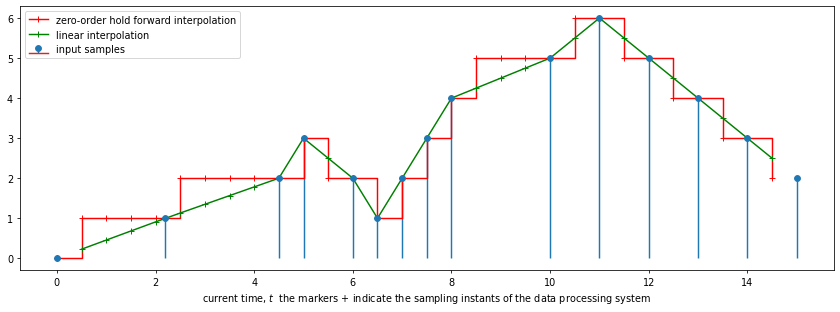

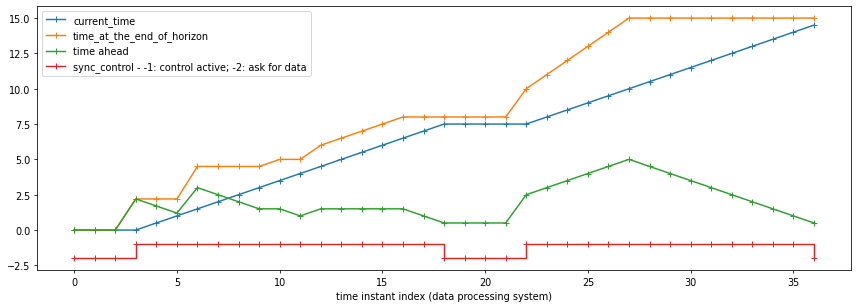

In [6]:
plot_timing()

### Test with a higher sampling rate

A similar test is performed with a higher sampling rate. The zero-order hold interpolation of the reference trajectory becomes visible in the timing diagrams.

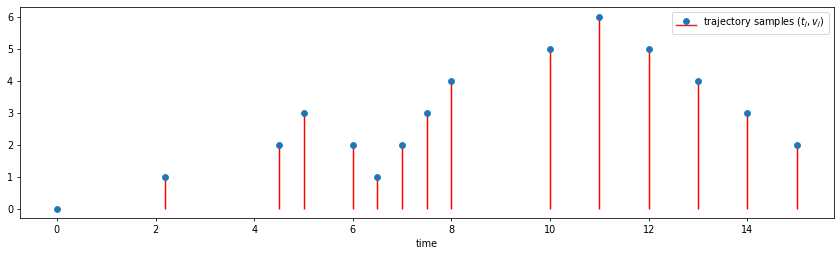

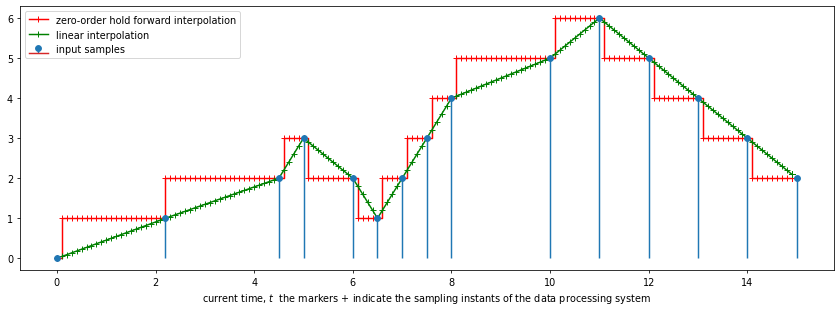

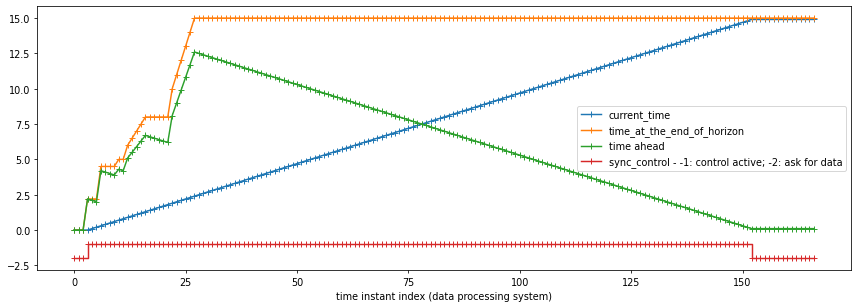

In [7]:
# define input data samples: samples can be valid or invalid, wherein invalid means they shall be ignore. 
nan = math.nan

async_input_data_valid     = np.array([ 1,   0,   1,   0,   0,   1,   0,   0,   0,   1,   0,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1 ])
reference_trajectory_time  = np.array([ 0, nan, 2.2, nan, nan, 4.5, nan, nan, nan, 5.0, nan, 6.0, 6.5,  7 , 7.5,   8, nan, nan, nan, nan, nan, 10 ,  11,  12,  13,  14,  15 ])
reference_trajectory_value = np.array([ 0, nan, 1.0, nan, nan, 2.0, nan, nan, nan, 3.0, nan, 2.0, 1.0, 2.0, 3.0, 4.0, nan, nan, nan, nan, nan, 5.0, 6.0, 5.0, 4.0, 3.0, 2.0 ])

plt.figure(figsize=(15,4), dpi=70)
plt.stem( reference_trajectory_time, reference_trajectory_value, 'r' )
plt.xlabel('time')
plt.legend(['trajectory samples ($t_j, v_j$)'])
plt.show()

# extend the end of the input data with invalid samples to prolong the simulation
async_input_data_valid     = np.concatenate(( async_input_data_valid,         np.zeros(140) ))
reference_trajectory_time  = np.concatenate(( reference_trajectory_time,  nan*np.zeros(140) ))
reference_trajectory_value = np.concatenate(( reference_trajectory_value, nan*np.zeros(140) ))

sync_control, current_time, time_at_the_end_of_horizon, time_ahead, head_index, current_read_position, elements_free_to_write, y_zero_order, y_linear = async_interpolation(0.1, async_input_data_valid, reference_trajectory_time, reference_trajectory_value) 

plot_timing()


In [8]:
sync_control[0:24]

array([-2., -2., -2., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [9]:
y_zero_order[0:24]

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [10]:
elements_free_to_write[0:24]

array([49., 48., 48., 47., 48., 48., 47., 47., 47., 47., 46., 46., 45.,
       44., 43., 42., 41., 41., 41., 41., 41., 41., 40., 39.])

# Using the generated c++ code

The implementation of the interpolator as defined by the (decorated) function 'async_interpolation' is placed into a new diagram. Names for the most important in- / outputs are added to obtain more meaningful variables names in c++. The command 'dy.generate_code' is used to build c++ code. For the sake of demonstrating how to use this generated code, an example simulation loop is given. Therefore, the generated c++ implementation is loaded into Python (via the just-in-time compiler cppyy). The step-function of the system is used to compute the samples of the output signals given the inputs.

In [11]:
dy.clear()
system = dy.enter_system()


# async_interpolation.original_function(  )
async_input_data_valid     = dy.system_input( dy.DataTypeInt32(1),   name='async_input_data_valid')
reference_trajectory_time  = dy.system_input( dy.DataTypeFloat64(1), name='reference_trajectory_time')
reference_trajectory_value = dy.system_input( dy.DataTypeFloat64(1), name='reference_trajectory_value')


sync_control, current_time, time_at_the_end_of_horizon, time_ahead, head_index, current_read_position, elements_free_to_write, y_zero_order, y_linear = async_interpolation.original_function(
    0.1, 
    async_input_data_valid, 
    reference_trajectory_time, 
    reference_trajectory_value
) 



# define output(s)
dy.append_output(sync_control,           'sync_control')
dy.append_output(elements_free_to_write, 'elements_free_to_write')
dy.append_output(current_time,           'current_time')
dy.append_output(y_zero_order,           'y_zero_order')
dy.append_output(y_linear,               'y_linear'    )

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.TargetWasm(), folder="generated/async_interpol", build=False)

compiled_system = dyexe.CompiledCode(code_gen_results)

compiling system Subsystem1000 (level 1)... 
compiling system Subsystem1001_wait_for_more_data (level 1)... 
compiling system Subsystem1002_process_data (level 1)... 
compiling system Subsystem1003_error (level 1)... 
compiling system Subsystem1005 (level 2)... 
compiling system Subsystem1004 (level 1)... 
compiling system simulation (level 0)... 
Generated code will be written to generated/async_interpol .


## Example implementation of a system that embedds the interpolator

First input data is defined:

In [12]:
# define input data samples 
reference_trajectory_time  = np.array([ 0, 2.2, 4.5, 5.0, 6.0, 6.5,  7 , 7.5,   8, 10 ,  11,  12,  13,  14,  15 ])
reference_trajectory_value = np.array([ 0, 1.0, 2.0, 3.0, 2.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 5.0, 4.0, 3.0, 2.0 ])

The example implementation simulates the generation of input data by taking samples from the pre-defined dataset above. In an real-world implementation the data could be generated on the fly. 

In [13]:
#
# In this example loop, the c++ step function of the generated code is called from within python (c++ code wrapped
# by cppyy).
#
# The prototype of the step function is
# 
#    // main step function 
#    void step(Outputs & outputs, Inputs const & inputs, int calculate_outputs, bool update_states, bool reset_states)
#
# and combines the functions 'system reset', 'update states', and the computation of the output signals.
# They can be triggered by the respective flags.
#

#
def get_next_input_sample(reference_trajectory_time, reference_trajectory_value):

    k_input = get_next_input_sample.cnt
    
    st, sv = math.nan, math.nan
    
    if k_input < len(reference_trajectory_time):
        reached_end = False
        
        st = reference_trajectory_time[  k_input ]
        sv = reference_trajectory_value[ k_input ]

        get_next_input_sample.cnt += 1
        
    else:
        reached_end = True

    return reached_end, st, sv

get_next_input_sample.cnt = 0




# Create an instance of the system (this is an instance of the c++ class wrapped by cppyy)
raw_cpp_instance = compiled_system.system_class()

# create data strutures to store I/O data
input_data  = compiled_system.system_class.Inputs()
output_data = compiled_system.system_class.Outputs()

# simulate n steps
n = 200

# storage for the output data
y_zero_order = math.nan * np.zeros(n)
y_linear     = math.nan * np.zeros(n)

real_world_sample_index = 0

# reset the states of the system
raw_cpp_instance.step(output_data, input_data, False, False, True)

# simulate a real time environment with regular sampling
require_next_sample = False

for i in range( 0, n ):

    #
    # simulate a component that generates the asynchronous input data
    #
    # Here, pre-defined data is used.
    #
    # Put your data-generating algorithm here...
    #
    
    if require_next_sample:
        print('passing next input sample at simulation step', i)
        
        reached_end, st, sv = get_next_input_sample(reference_trajectory_time, reference_trajectory_value)

        if reached_end:
            break
        
        input_data.reference_trajectory_time  = st
        input_data.reference_trajectory_value = sv

        # if true, a new sample of input data (t, v) is transmitted to the interpolator
        input_data.async_input_data_valid     = True
        
        # just put one sample and wait until the next one is requested
        require_next_sample = False
    else:
        
        input_data.async_input_data_valid     = False
    
    
    # output computation (writes results into output_data)
    #
    # Please note: it is important that this step is performed *before*
    # updating the states.
    raw_cpp_instance.step(output_data, input_data, True, False, False)

    # update (does not change output_data)
    raw_cpp_instance.step(output_data, input_data, False, True, False)
    
    # watch out to not cause an buffer overflow by passing too much data that cannot be
    # consumed in time! (not checked here)
    elements_free_to_write = output_data.elements_free_to_write
    
    # print('output_data.sync_control', output_data.sync_control)
    
    if output_data.sync_control == -3:
        print('internal error')
        
        break
        

    if output_data.sync_control == -2:
        #
        # The interpolator came to the point at which it urgently needs more
        # input data. Hence, the data-generating algorithm (above) is required
        # to produce new data.
        #
        
        require_next_sample = True

        continue
        
    if output_data.sync_control == -1:
        # The interpolation results are valid so store them or apply to something (e.g., sending to an actuator)
        
        y_zero_order[real_world_sample_index] = output_data.y_zero_order
        y_linear[real_world_sample_index]     = output_data.y_linear
        
        real_world_sample_index += 1
        


passing next input sample at simulation step 1
passing next input sample at simulation step 2
passing next input sample at simulation step 3
passing next input sample at simulation step 48
passing next input sample at simulation step 49
passing next input sample at simulation step 65
passing next input sample at simulation step 66
passing next input sample at simulation step 77
passing next input sample at simulation step 78
passing next input sample at simulation step 89
passing next input sample at simulation step 90
passing next input sample at simulation step 121
passing next input sample at simulation step 122
passing next input sample at simulation step 143
passing next input sample at simulation step 144
passing next input sample at simulation step 165


The computed results are:

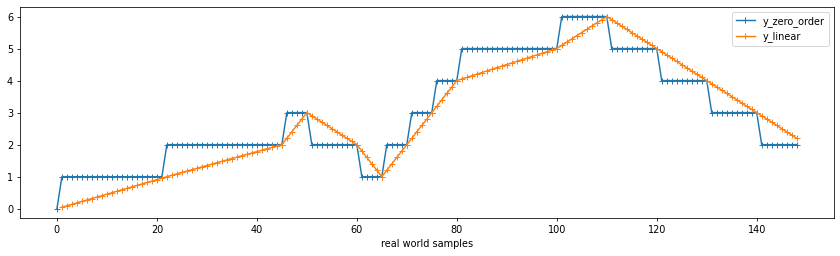

In [14]:
plt.figure(figsize=(15,4), dpi=70)
plt.plot(  y_zero_order, '+-' )
plt.plot(  y_linear, '+-' )
plt.xlabel('real world samples')
plt.legend(['y_zero_order', 'y_linear'])
plt.show()

The generated c++ code is as follows:

In [15]:
# show the generated source code (uncomment as needed)

# from IPython.display import Code
# Code(data=code_gen_results['algorithm_sourcecode'], language='c++')

# Tests

To prevent this example from unexpectedly braking and to test ORTD...

In [16]:
nan = math.nan

async_input_data_valid     = np.array([ 1,   0,   1,   0,   0,   1,   0,   0,   0,   1,   0,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1 ])
reference_trajectory_time  = np.array([ 0, nan, 2.2, nan, nan, 4.5, nan, nan, nan, 5.0, nan, 6.0, 6.5,  7 , 7.5,   8, nan, nan, nan, nan, nan, 10 ,  11,  12,  13,  14,  15 ])
reference_trajectory_value = np.array([ 0, nan, 1.0, nan, nan, 2.0, nan, nan, nan, 3.0, nan, 2.0, 1.0, 2.0, 3.0, 4.0, nan, nan, nan, nan, nan, 5.0, 6.0, 5.0, 4.0, 3.0, 2.0 ])


# extend the end of the input data with invalid samples to prolong the simulation
async_input_data_valid     = np.concatenate(( async_input_data_valid,     nan*np.zeros(10) ))
reference_trajectory_time  = np.concatenate(( reference_trajectory_time,  nan*np.zeros(10) ))
reference_trajectory_value = np.concatenate(( reference_trajectory_value, nan*np.zeros(10) ))

def assert_equal( x, y ):
    assert np.size(np.where(( x == np.array( y )) == False)) == 0

def assert_approx(x, y, eps=0.00001):
    assert np.size(np.where(  np.abs( x - np.array(y) ) > eps )  ) == 0


In [17]:
sync_control, current_time, time_at_the_end_of_horizon, time_ahead, head_index, current_read_position, elements_free_to_write, y_zero_order, y_linear = async_interpolation(0.5, async_input_data_valid, reference_trajectory_time, reference_trajectory_value) 

In [18]:
sync_control

array([-2., -2., -2., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -2., -2., -2., -2., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -2.])

In [19]:
assert_equal( sync_control , [-2., -2., -2., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -2., -2., -2., -2., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -2.] )

In [20]:
time_ahead

array([0. , 0. , 0. , 2.2, 1.7, 1.2, 3. , 2.5, 2. , 1.5, 1.5, 1. , 1.5,
       1.5, 1.5, 1.5, 1.5, 1. , 0.5, 0.5, 0.5, 0.5, 2.5, 3. , 3.5, 4. ,
       4.5, 5. , 4.5, 4. , 3.5, 3. , 2.5, 2. , 1.5, 1. , 0.5])

In [21]:
assert_approx( time_ahead , [0. , 0. , 0. , 2.2, 1.7, 1.2, 3. , 2.5, 2. , 1.5, 1.5, 1. , 1.5,
       1.5, 1.5, 1.5, 1.5, 1. , 0.5, 0.5, 0.5, 0.5, 2.5, 3. , 3.5, 4. ,
       4.5, 5. , 4.5, 4. , 3.5, 3. , 2.5, 2. , 1.5, 1. , 0.5] )

In [22]:
head_index

array([-1.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  4.,
        5.,  6.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  9., 10., 11., 12.,
       13., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.])

In [23]:
assert_equal( head_index , [-1.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  4.,
        5.,  6.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  9., 10., 11., 12.,
       13., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.] )

In [24]:
current_read_position

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
        3.,  4.,  4.,  5.,  6.,  7.,  7.,  7.,  7.,  7.,  8.,  9.,  9.,
        9.,  9., 10., 10., 11., 11., 12., 12., 13., 13., 14.])

In [25]:
assert_equal( current_read_position , [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
        3.,  4.,  4.,  5.,  6.,  7.,  7.,  7.,  7.,  7.,  8.,  9.,  9.,
        9.,  9., 10., 10., 11., 11., 12., 12., 13., 13., 14.]  )

In [26]:
y_zero_order

array([0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 2., 2., 1.,
       2., 3., 3., 3., 3., 3., 4., 5., 5., 5., 5., 6., 6., 5., 5., 4., 4.,
       3., 3., 2.])

In [27]:
assert_equal( y_zero_order , [0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 2., 2., 1.,
       2., 3., 3., 3., 3., 3., 4., 5., 5., 5., 5., 6., 6., 5., 5., 4., 4.,
       3., 3., 2.] )

In [28]:
elements_free_to_write

array([49., 48., 48., 47., 48., 48., 47., 47., 48., 48., 47., 47., 46.,
       46., 46., 45., 45., 46., 47., 47., 47., 47., 46., 46., 46., 45.,
       44., 43., 44., 44., 45., 45., 46., 46., 47., 47., 48.])